<h1 style="text-align:center;">Camera Trap Application</h1>


<h2 style="text-align:center;">Introduction</h2>

Camera traps are a widely used tool in wildlife conservation. They are used to monitor animal populations and gather data on animal behaviour. However, the large amount of data generated by camera traps makes it difficult to process and analyse the data.<br> 
In this second part, we will develop a machine learning model that can automatically classify animal species captured by camera traps in the Dedan Kimathi University Wildlife Conservancy.<br> 
By achieving this, we hope to gain valuable insights into animal behaviour and contribute to wildlife conservation efforts.


Installing the required python dependencies

The modules_used file contains a list of all the python modules used in this notebook. You can install them using the following command:

```python
The helper_funcs file contain some helper functions used in this notebook to help in our model lifecycle from the data to deployment on the OpenMV Cam.

<h2 style="text-align:center;">Data Preparation</h2>
In this section, we’ll extract the data given and prepare it for analysis.<br>
We’ll do this by splitting the data into training, validation and test sets.
Splitting data into training, validation, and test sets is essential as it helps assess the performance of a model by providing a way to train the model on one portion of the data, tune its parameters on another (validation set), and finally evaluate its generalization on unseen data (test set), which helps avoid overfitting and ensures the model's reliability.

### Steps

- Unzip the dataset
- Split the dataset into train, validation and test sets
- From the metadata build the train, validation and test images and labels folders
- Load the Images from directory


In [1]:
from modules_used import *

In [3]:
# The Modules required for this tutorial
from modules_used import *

# Extract the dataset to the current working directory
with zipfile.ZipFile('./dataset.zip', 'r') as zip:
    zip.extractall(f'{os.getcwd()}')

print('Dataset extracted successfully!')
    
# load the train and test metadata
data_dir = os.path.join(os.getcwd(), 'dataset')
train_metadata_path = os.path.join(data_dir, 'train.csv')
test_metadata_path = os.path.join(data_dir, 'test.csv')

# read the data
train_df = pd.read_csv(train_metadata_path)
test_df = pd.read_csv(test_metadata_path)

# classes to use for training
classes = ['IMPALA', 'WARTHOG', 'ZEBRA']

# filter the train and test sets to only include the desired classes
train_df = train_df[train_df['Species'].isin(classes)]
test_df = test_df[test_df['Species'].isin(classes)]

# split the train set to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

# the length of all the sets
sets_len = len(train_df) + len(val_df) + len(test_df)

# print the length of each set
print(f'Train set length: {len(train_df)}, {len(train_df)/sets_len*100:.2f}%')
print(f'Validation set length: {len(val_df)}, {len(val_df)/sets_len*100:.2f}%')
print(f'Test set length: {len(test_df)}, {len(test_df)/sets_len*100:.2f}%')

# build the image datasets
train_dir = os.path.join(data_dir, 'train') # location of the training data
val_dir = os.path.join(data_dir, 'train') # location of the validation data
test_dir = os.path.join(data_dir, 'test') # location of the test data

# create the training, validation and test directories
helper.split_data(train_dir, train_df, 'train')
helper.split_data(val_dir, val_df, 'val')
helper.split_data(test_dir, test_df, 'test')

Dataset extracted successfully!
Train set length: 1321, 76.36%
Validation set length: 234, 13.53%
Test set length: 175, 10.12%


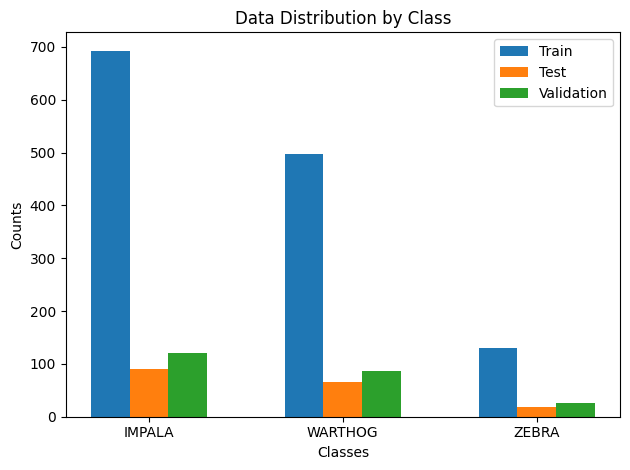

In [4]:
train_images_path = 'train'
val_images_path = 'val'
test_images_path = 'test'

# Visualize the data distribution
helper.data_distribution(train_images_path, val_images_path, test_images_path, plot=True)

<h3 style="text-align:center;">Neural Networks</h3>


Deep Learning is based on artificial neural networks which have been around in some form since the late 1950s. The networks are built from individual parts approximating neurons, typically called units or simply "neurons." Each unit has some number of weighted inputs. These weighted inputs are summed together (a linear combination) then passed through an activation function to get the unit's output.

<div style="text-align:center;">
    <img src="simple_neuron.png" width="400px" alt="Simple Neuron">
</div>


Mathematically this looks like: 

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

With vectors this is the dot/inner product of two vectors:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$

<h3 style="text-align:center;">Tensors</h3>
It turns out neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.

Found 1321 files belonging to 3 classes.
Found 234 files belonging to 3 classes.
Found 175 files belonging to 3 classes.


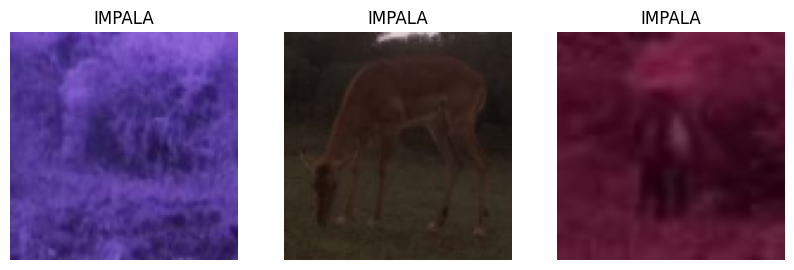

In [5]:
BATCH_SIZE = 3
IMG_SIZE = (96, 96)

# Load the images to tensors
train_tensors = helper.load_images_from_dir(train_images_path, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_tensors = helper.load_images_from_dir(val_images_path, BATCH_SIZE, IMG_SIZE, shuffle=False)
test_tensors = helper.load_images_from_dir(test_images_path, BATCH_SIZE, IMG_SIZE, shuffle=False)

# extract the images and labels
train_images, train_labels = helper.extract_images_and_labels(train_tensors, normalize=True, categorical=True)
val_images, val_labels = helper.extract_images_and_labels(val_tensors, normalize=True, categorical=True)
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=True)

# Define the labels dictionary
labels = {
    0: 'IMPALA',
    1: 'WARTHOG',
    2: 'ZEBRA'
}

# Visualize the images
helper.visualize_images(train_tensors, BATCH_SIZE, class_names=list(labels.values()))

<h3 style="text-align:center;">Data Augmentation</h3>
This is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data.<br>
The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations

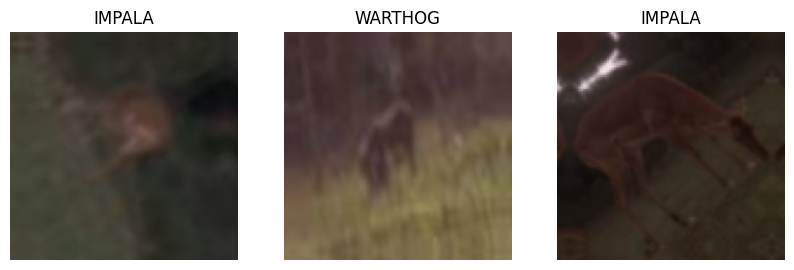

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

# augment the train tensors from directory
# Apply data augmentation to train tensors
augmented_train_tensors = train_tensors.map(lambda x, y: (data_augmentation(x, training=True), y))

# extract the augmented train images and labels
augmented_train_images, augmented_train_labels = helper.extract_images_and_labels(augmented_train_tensors, normalize=True, categorical=True)

# visualize the augmented images
helper.visualize_images(augmented_train_tensors, BATCH_SIZE, class_names=list(labels.values()))

<h3 style="text-align:center;">Feature Distribution</h3>

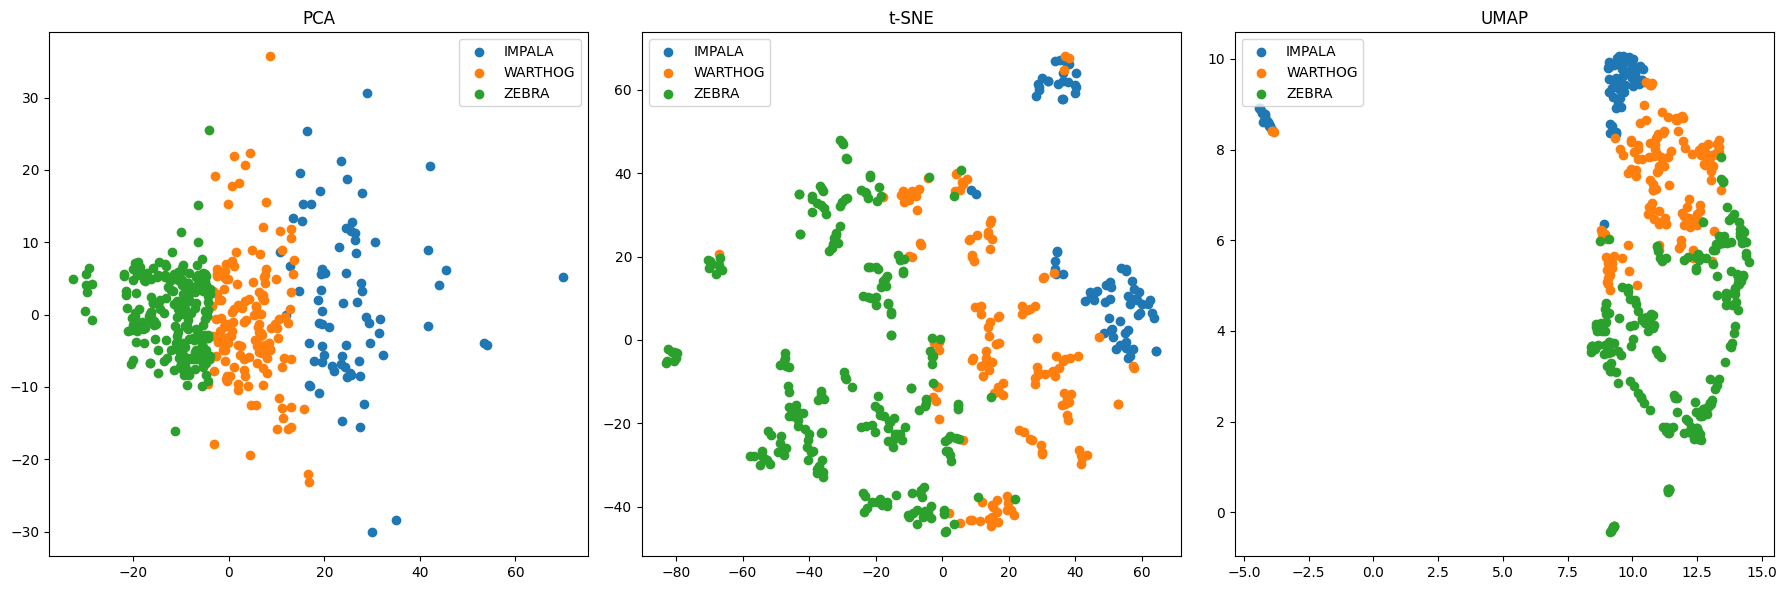

In [7]:
# Call the function with your train_images, train_labels, and labels
helper.visualize_dimensionality_reduction(augmented_train_images, augmented_train_labels, labels)


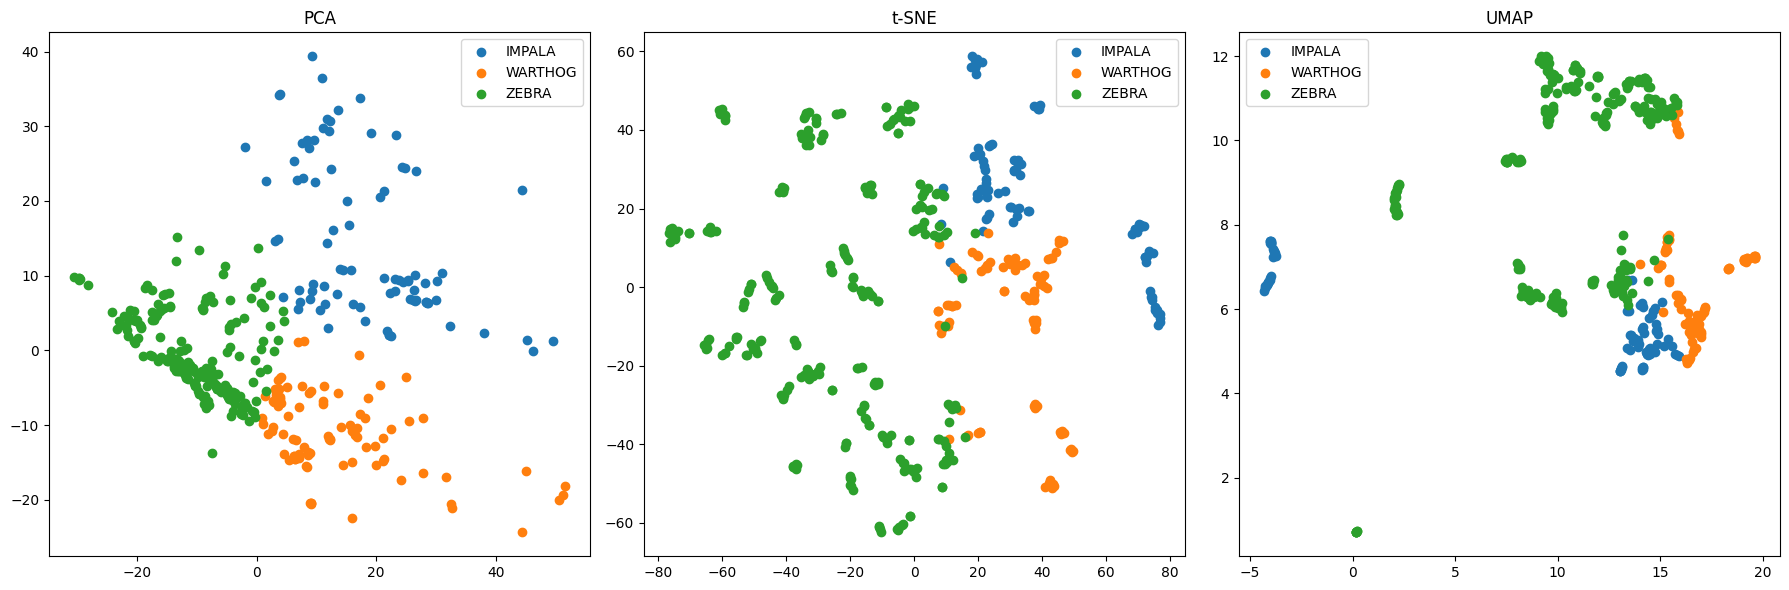

In [8]:
# Call the function with your train_images, train_labels, and labels
helper.visualize_dimensionality_reduction(train_images, train_labels, labels)


<h3 style="text-align:center;">Model Development</h3>
Leveraging Transfer Learning, we will use a pre-trained model to develop our model. We will use the MobileNet model which is a lightweight model that is suitable for mobile and embedded vision applications. We will use the pre-trained model and add a few layers to it to make it suitable for our application.<br>


In [9]:
# Model Architecture leveraging pretrained weights
LEARNING_RATE = 0.005
NUM_CLASSES = 3
DROPOUT = 0.05
WEIGHT_DECAY = 0.00000
ACTIVATION = 'softmax'
OPTIMIZER = 'adam'
MOMENTUM = 0.9

model = helper.build_model(num_classes=NUM_CLASSES, dropout=DROPOUT, 
                   weight_decay=WEIGHT_DECAY, activation=ACTIVATION, 
                   optimizer=OPTIMIZER, momentum=MOMENTUM,
                   learning_rate=LEARNING_RATE)

<h3 style="text-align:center;">Defining Callbacks</h3>
Monitoring the minimum validation loss and saving the model with the lowest validation loss. We will use the ModelCheckpoint callback to save the model with the lowest validation loss.<br>
We will reduce the learning rate when the validation loss has stopped improving using the ReduceLROnPlateau callback after monitoring for 5 eopchs then reduce by half.<br>
We will stop training the model when the validation loss has stopped improving using the EarlyStopping callback after monitoring for 15 epochs.

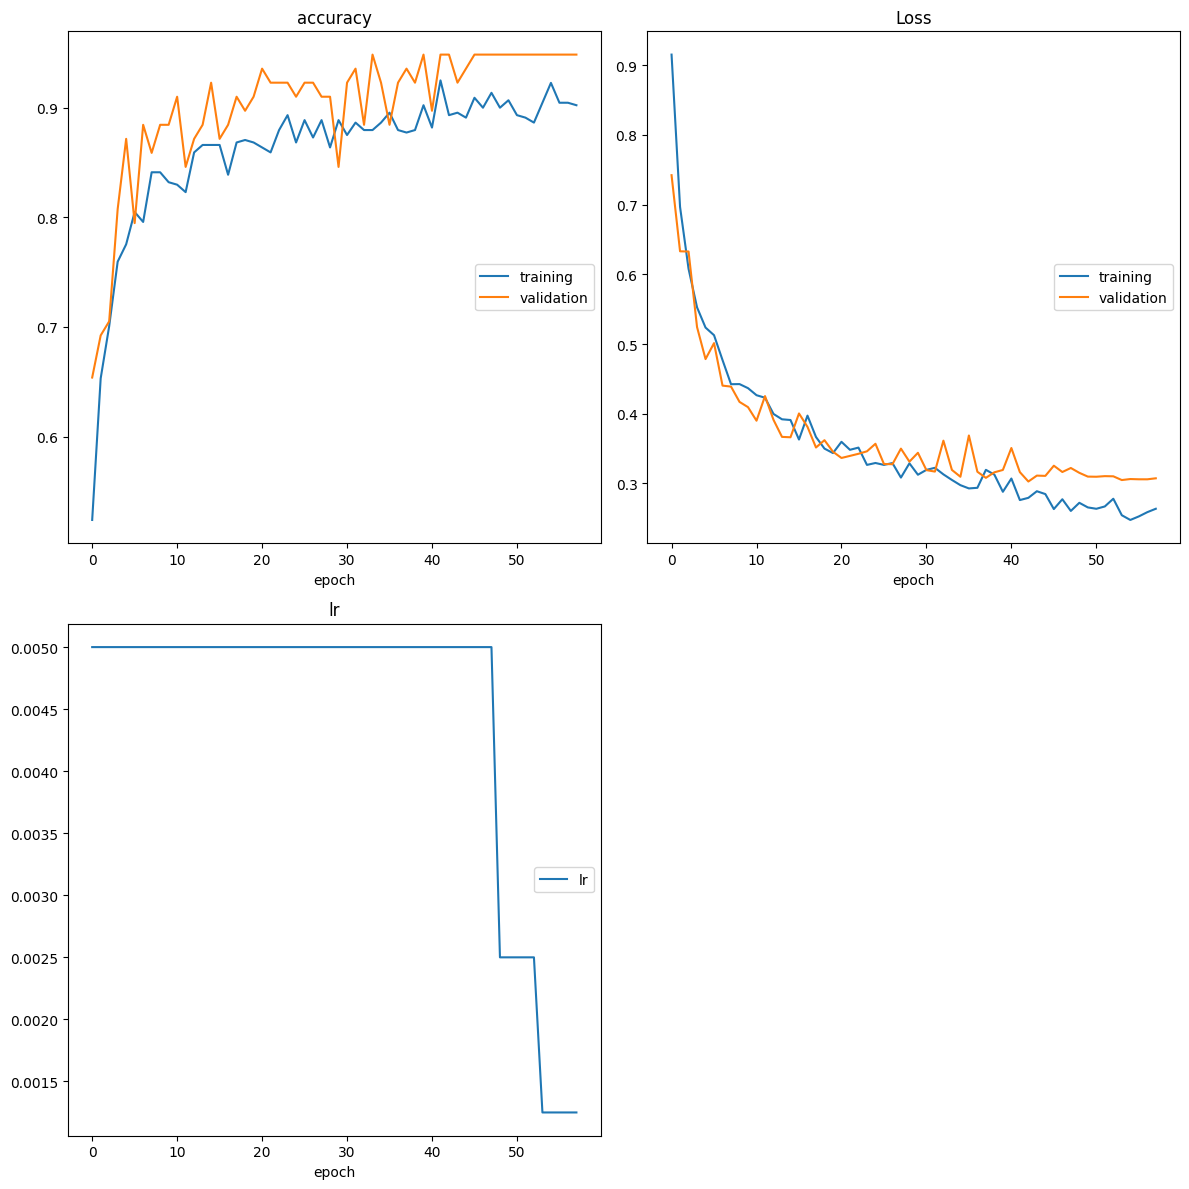

14/14 - 1s - loss: 0.2636 - accuracy: 0.9025 - val_loss: 0.3073 - val_accuracy: 0.9487 - lr: 0.0012 - 1s/epoch - 98ms/step


In [10]:
EPOCHS = 100
CHECKPOINT_PATH = 'model.h5'
MONITOR = 'val_loss'
MODE = 'min'
PATIENCE = 5 # number of epochs with no improvement after which learning rate will be reduced.
FACTOR = 0.5 # factor by which the learning rate will be reduced. new_lr = lr * factor
# defining the callbacks
callbacks = helper.define_callbacks(checkpoint_path=CHECKPOINT_PATH,
                                     monitor=MONITOR, mode=MODE, 
                                     patience=PATIENCE, factor=FACTOR)


# Train the model
history = model.fit(
    augmented_train_images,
    augmented_train_labels,
    epochs=EPOCHS,
    validation_data=(val_images, val_labels),
    verbose=2,
    callbacks=callbacks
)

<h3 style="text-align:center;">Model Evaluation</h3>
Evaluating machine learning models for image classification is crucial as it determines how accurately they can categorize images. This evaluation process provides valuable insights into a model's performance by measuring its ability to correctly identify objects or patterns in images. 

<h3 style="text-align:center;">Classification Report</h3>

### Accuracy
Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.<br>
### Precision
Precision is a measure of how many of the positive predictions made are correct (true positives).<br>
### Recall
Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.<br>
For more information on the classification report, check out this [link](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9).

2/2 [==============================] - 1s 34ms/step - loss: 1.1622 - accuracy: 0.7627
[1.1622314453125, 0.7627118825912476]
2/2 [==============================] - 1s 26ms/step


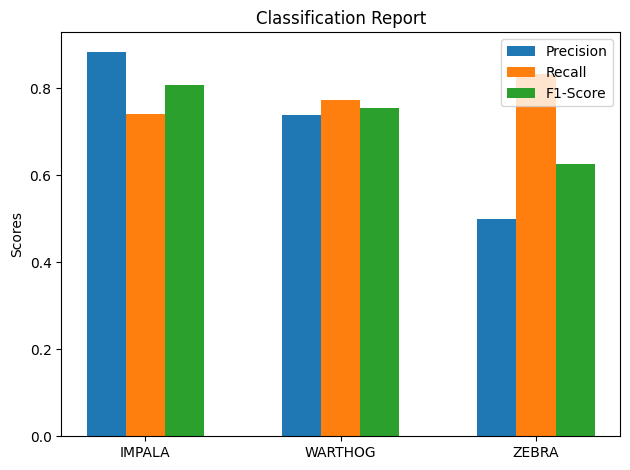

In [11]:
# evaluate the best saved model
model = tf.keras.models.load_model('model.h5')

print(model.evaluate(test_images, test_labels))

helper.plot_classification_report(model, test_tensors, labels)


<h3 style="text-align:center;">Sanity Check</h3>
We will use the model to predict the class of a random image from the test set. We will then plot the image and the predicted class to see if the model is working as expected.

Class: ZEBRA
1/1 [==============================] - 0s 36ms/step


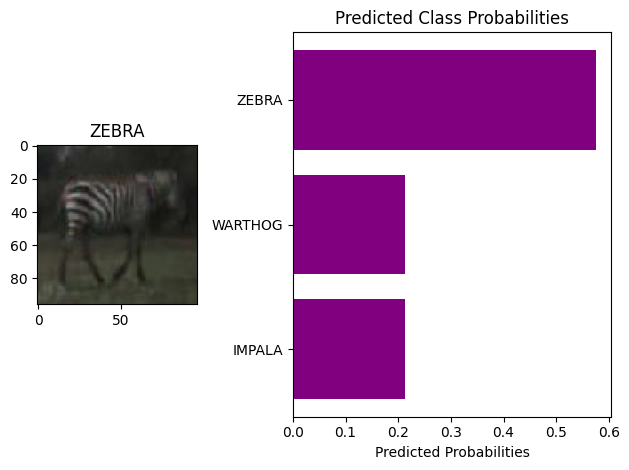

In [157]:
helper.inference_model(model, mapping=labels)

<h3 style="text-align:center;">Model Quantization</h3>
Quantization is a model size reduction technique that converts model weights from high-precision floating-point representation to low-precision floating-point (FP) or integer (INT) representations<br>
We will use the TFLiteConverter to convert the model to a TFLite model and then quantize it to reduce the model size we'll convert from the default float32 to int8 supported by the OpenMV Cam which is our target device.<br>
We'll then assess the performance of the quantized model.

In [12]:
def representative_dataset_generator():
    for data, _ in val_tensors:
        yield [data]  # shape: (batch_size, height, width, channels)


# load the best model
model = tf.keras.models.load_model('model.h5')

# quantizing the model to int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = representative_dataset_generator
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.dtypes.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

hub_m = converter.convert()

# save the keras model
with open('model.tflite', 'wb') as f:
    f.write(hub_m)  

# evaluate the tflite model
print('Evaluating tflite model...')
helper.evaluate_tflite('model.tflite', test_tensors, dtype='int8')

INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpmiw08brv\assets


INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpmiw08brv\assets


Evaluating tflite model...


0.5254237288135594

<h3 style="text-align:center;">Model Profiling</h3>
We will use the Edge Impulse API for this case to evaluate the performance on the target device

In [ ]:
import edgeimpulse as ei
import json
# add the api key to edge impulse
with open('config.json') as f:
    config = json.load(f)


api_key = config['edge_impulse_api_key']
ei.API_KEY = api_key
    
# the supported devices
profile_devices = ei.model.list_profile_devices()
print(profile_devices)

# target device is open mv cam h7 plus
model_profile = ei.model.profile(model='model.tflite')

In [ ]:
# Profiling the model to check the compatibility with the MCU
model_profile.summary()

<h3 style="text-align:center;">Model Deployment</h3>
In this section we'll deploy the model to the OpenMV Cam and test it on the device.
We'll write our classes to a labels.txt file that will be read by the OpenMV Cam to display the predicted class during inferencing.<br>

In [86]:
# Write the class names to text file
with open('labels.txt', 'w') as f:
    for item in list(train_tensors.class_names):
        f.write("%s\n" % item)

In [ ]:
# create a folder called openmv-model if it doesn't exist
if not os.path.exists('openmv-model'):
    os.mkdir('openmv-model')
# move the tflite file and labels.txt file into the openmv-model folder

os.rename('mobileweights_6classes4.tflite', 'openmv-model/trained449.tflite')

'''Uncomment and run this once if the file does not exist'''
# os.rename('labels.txt', 'openmv-model/labels.txt')

In [57]:
# evaluate the performance of the tflite model
helper.evaluate_tflite('openmv-model/trained444.tflite', test_tensors, dtype='float32')

0.11864406779661017